# Collaborative Filtering for Movie Recommendations

## Introduction

This example demonstrates Collaborative filtering using the Movielens dataset to recommend movies to users. The MovieLens ratings dataset lists the ratings given by a set of users to a set of movies. Our goal is to be able to predict ratings for movies a user has not yet watched. The movies with the highest predicted ratings can then be recommended to the user.

The steps in the model are as follows:

1. Map user ID to a "user vector" via an embedding matrix
2. Map movie ID to a "movie vector" via an embedding matrix
3. Compute the dot product between the user vector and movie vector, to obtain the a match score between the user and the movie (predicted rating).
4. Train the embeddings via gradient descent using all known user-movie pairs.

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import random
import os
from urllib import request
import sys
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    np.random.seed(random_seed)
    random.seed(random_seed)

set_seed(72)

In [4]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
annotation_folder = os.path.abspath(".") + "/dataset/"
file_name = "ml-latest-small.zip"
url = "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
savefile = os.path.join(annotation_folder, file_name)

if not os.path.exists(annotation_folder):
    os.makedirs(annotation_folder)
    print('Folder creation complete!')
else:
    print('The folder already exists.')
    
if not os.path.isfile(savefile):
    request.urlretrieve(url, savefile)
    with ZipFile(savefile, 'r') as zip_ref:
        zip_ref.extractall(annotation_folder)
    print('File creation complete!')
else:
    print('The File already exists.')

The folder already exists.
The File already exists.


In [5]:
df = pd.read_csv(os.path.join(annotation_folder, "ml-latest-small/ratings.csv"))
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [6]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)


Number of users: 610, Number of Movies: 9724, Min rating: 0.5, Max rating: 5.0


In [7]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

In [8]:
x_train, y_train

(array([[ 431, 4730],
        [ 287,  474],
        [ 598, 2631],
        ...,
        [ 589, 5054],
        [ 135,  636],
        [ 274, 3747]]),
 array([0.88888889, 0.55555556, 0.55555556, ..., 0.55555556, 1.        ,
        0.11111111]))

In [9]:
class CustomDataset(Dataset): 
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, index): 
        return self.x[index], self.y[index]

In [10]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 8,
          'pin_memory' : True}

x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).float()
x_val = torch.from_numpy(x_val)
y_val = torch.from_numpy(y_val).float()

tr_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
trainloader = DataLoader(dataset=tr_dataset, **params)
validloader = DataLoader(dataset=val_dataset, **params)

In [11]:
EMBEDDING_SIZE = 50


class RecommenderNet(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_embedding = nn.Embedding(num_movies,embedding_size)
        self.movie_bias = nn.Embedding(num_movies, 1)
        
        torch.nn.init.kaiming_normal_(self.user_embedding.weight)
        torch.nn.init.kaiming_normal_(self.movie_embedding.weight)
        
        self.sigmoid=nn.Sigmoid()

    def forward(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = torch.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        x = self.sigmoid(x)
        return x


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, eps=1e-7, weight_decay=1e-6)

In [12]:
EPOCHS = 20
loss_fn = nn.BCELoss()

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)

class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [14]:
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None, progress_display=False):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    progress = ProgressMeter(
        len(train_data),
        [batch_time, losses],
        prefix="Epoch: [{}]".format(epoch))

    model.train()
    end = time.time()
    for idx, [x, y] in enumerate(train_data):
        optimizer.zero_grad(set_to_none=True)
        scaler = torch.cuda.amp.GradScaler()
        
        input = x.to(device)
        target = y.to(device)
        
        with torch.cuda.amp.autocast(enabled=use_fp16):
            predictions = model(input).squeeze()
            train_loss = loss_fn(predictions, target)
        if use_fp16:
            scaler.scale(train_loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            if max_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            optimizer.step()
            
        losses.update(train_loss.item(), input.size(0))
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if progress_display == True and idx % 5 == 0:
            progress.display(idx)
        
    return losses.avg

In [15]:
def validation(model, val_data, loss_fn):
    losses = AverageMeter('Loss', ':.4e')
    model.eval()
    val_loss = 0
    for idx, [x, y] in enumerate(val_data):
        input = x.to(device)
        target = y.to(device)
        with torch.no_grad():
            predictions = model(input).squeeze()
            val_loss = loss_fn(predictions, target)
        losses.update(val_loss.item(), input.size(0))
        
    return losses.avg

In [16]:
%%time
best = {"val_loss": sys.float_info.min}
history = dict()
# early_stopping = EarlyStopping(patience=10, verbose=1)

for epoch in range(1, EPOCHS+1):
    epoch_loss = train(model, trainloader, optimizer, loss_fn, use_fp16=False)
    val_loss = validation(model, validloader, loss_fn)
    
    history.setdefault('loss', []).append(epoch_loss) 
    history.setdefault('val_loss', []).append(val_loss)
    
    print(f"[Train] Epoch : {epoch:^3}"\
        f"  Train Loss: {epoch_loss:.4}"\
        f"  Valid Loss: {val_loss:.4}")

    if val_loss > best["val_loss"]:
            best["state"] = model.state_dict()
            best["epoch"] = epoch
#     if early_stopping.validate(val_loss):
#         break

[Train] Epoch :  1   Train Loss: 1.123  Valid Loss: 1.041
[Train] Epoch :  2   Train Loss: 1.063  Valid Loss: 1.064
[Train] Epoch :  3   Train Loss: 1.093  Valid Loss: 0.9118
[Train] Epoch :  4   Train Loss: 1.05  Valid Loss: 0.9151
[Train] Epoch :  5   Train Loss: 1.004  Valid Loss: 0.8317
[Train] Epoch :  6   Train Loss: 0.9482  Valid Loss: 0.8415
[Train] Epoch :  7   Train Loss: 0.8821  Valid Loss: 0.7659
[Train] Epoch :  8   Train Loss: 0.8446  Valid Loss: 0.7815
[Train] Epoch :  9   Train Loss: 0.805  Valid Loss: 0.7283
[Train] Epoch : 10   Train Loss: 0.7803  Valid Loss: 0.7664
[Train] Epoch : 11   Train Loss: 0.7717  Valid Loss: 0.6996
[Train] Epoch : 12   Train Loss: 0.7333  Valid Loss: 0.7171
[Train] Epoch : 13   Train Loss: 0.7169  Valid Loss: 0.6745
[Train] Epoch : 14   Train Loss: 0.6998  Valid Loss: 0.7078
[Train] Epoch : 15   Train Loss: 0.6929  Valid Loss: 0.6599
[Train] Epoch : 16   Train Loss: 0.675  Valid Loss: 0.696
[Train] Epoch : 17   Train Loss: 0.6703  Valid Loss

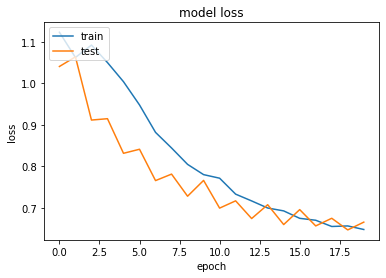

In [17]:
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [18]:
movie_df = pd.read_csv(os.path.join(annotation_folder, "ml-latest-small/movies.csv"))

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = torch.from_numpy(np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)).to(device)
ratings = model(user_movie_array).squeeze().cpu().detach().numpy()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Showing recommendations for user: 163
Movies with high ratings from user
--------------------------------
George of the Jungle (1997) : Children|Comedy
Air Force One (1997) : Action|Thriller
Game, The (1997) : Drama|Mystery|Thriller
Good Will Hunting (1997) : Drama|Romance
As Good as It Gets (1997) : Comedy|Drama|Romance
--------------------------------
Top 10 movie recommendations
--------------------------------
Panic (2000) : Drama
Lumumba (2000) : Drama
Pierrot le fou (1965) : Crime|Drama
Enter the Void (2009) : Drama
Mesrine: Public Enemy #1 (L'ennemi public n°1) (2008) : Action|Crime
30 Minutes or Less (2011) : Action|Comedy|Crime
Parental Guidance (2012) : Comedy
L.A. Slasher (2015) : Comedy|Crime|Fantasy
The Spirit of Christmas (1995) : Animation|Comedy
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama


---